In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import math

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import ImageFile

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from pathlib import Path

In [ ]:
# creating a bunch of functions to load the data

def load_metadata(metadata_path='fungi-clef-2025/metadata/FungiTastic-FewShot/', image_path='fungi-clef-2025/images/FungiTastic-FewShot/'):   # Load the metadata for each data split
    """Load the metadata for each data split."""
    # Load the metadata for each split
    train_metadata = pd.read_csv(os.path.join(metadata_path, 'FungiTastic-FewShot-Train.csv'))
    test_metadata = pd.read_csv(os.path.join(metadata_path, 'FungiTastic-FewShot-Val.csv'))

    train_metadata = train_metadata.dropna(subset=["class"])
    train_metadata = train_metadata.groupby('class').filter(lambda x: len(x) > 1)

    train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.2, stratify=train_metadata["class"])
    
    # Label each split
    train_metadata["split"] = "train"
    val_metadata["split"] = "val"
    test_metadata["split"] = "test"

    # Join all of the data together
    df_metadata = pd.concat([train_metadata, val_metadata, test_metadata])

    # Add the full image location for each image
    # Options for image size include 300p, 500p, 720p, fullsize 
    for idx, row in df_metadata.iterrows():
        if row["split"] in ["train", "val"]:
            path = os.path.join(image_path, f"train/300p/{row['filename']}")
        else:
            path = os.path.join(image_path, f"val/300p/{row['filename']}")
        df_metadata.at[idx, "image_path"] = path

    return df_metadata


def mapping(df, label):   # Map the labels to integers
    le = LabelEncoder()
    le.fit(df[label])
    df[label + "_label"] = df[label]
    df[label + "_idx"] = le.transform(df[label])

    return df


def apply_random_augmentation(X):   # Apply random augmentation to the image
    random_number = random.randint(1, 4)

    if random_number == 1:
        return tf.image.flip_left_right(X)
    if random_number == 2:
        return tf.image.flip_up_down(X)
    if random_number == 3:
        return tf.image.adjust_brightness(X, delta=0.3)
    if random_number == 4:
        return tf.image.adjust_contrast(X, contrast_factor=3)


def preprocess_image_tf(image, target_size):   # Preprocess the image keeping the aspect ratio
    # Load image using designated filepath
    img = load_img(image)

    # Get original dimensions
    original_height = tf.cast(tf.shape(img)[0], tf.float32)
    original_width = tf.cast(tf.shape(img)[1], tf.float32)
    
    # Calculate scaling factor to maintain aspect ratio
    height_scale = target_size / original_height
    width_scale = target_size / original_width
    scale = tf.minimum(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = tf.cast(tf.math.round(original_height * scale), tf.int32)
    new_width = tf.cast(tf.math.round(original_width * scale), tf.int32)
    
    # Resize the image while maintaining aspect ratio
    resized_img = tf.image.resize(img, [new_height, new_width], method='bilinear')
    
    # Use resize_with_pad to add padding to make the image square
    padded_img = tf.image.resize_with_pad(
        resized_img, 
        target_size, 
        target_size, 
        method='bilinear'
    )
    
    # Normalize pixel values to [0,1]
    normalized_img = tf.cast(padded_img, tf.float32) / 255.0
    
    return normalized_img


def load_images_and_labels(df, image_size):   # Load the images and labels based on the metadata
    """Load the images and labels based on the metadata frame passed in."""
    images = []
    labels_class = []
    # labels_poison = []
    # labels_species = []
    variables = []

    for idx, row in df.iterrows():
        # Load and save the image as an array
        # img = load_img(row["image_path"], target_size=image_size)
        img = preprocess_image_tf(row["image_path"], image_size)
        img_arr = img_to_array(img)
        images.append(img_arr)

        # Append the class to the list of labels
        labels_class.append(row["class_idx"])

        # labels_poison.append(row["poisonous"])
        # labels_species.append(row["species_idx"])
        # variables.append((row["latitude"], row["longitude"], row["elevation"], row["countryCode"], row["region"], row["substrate"], row["habitat"], row["landcover"]))
        variables.append((row["elevation"], row["habitat"]))

    # Stack and convert into a numpy array
    images = np.stack(images)

    # Cast label list to np.array for easier manipulation
    labels_class = np.array(labels_class)
    # labels_poison = np.array(labels_poison)
    # labels_species = np.array(labels_species)
    variables = np.array(variables)

    return images, labels_class, variables #, labels_poison, labels_species, variables

In [3]:
md_df = load_metadata()

md_df = mapping(md_df, "class")

images, labels_class, variables = load_images_and_labels(md_df, 224)

In [4]:
# Re-split the images and their labels
train_idx = md_df["split"] == "train"
val_idx = md_df["split"] == "val"
test_idx = md_df["split"] == "test"

train_images = images[train_idx]
train_labels_class = labels_class[train_idx]
# train_labels_poison = labels_poison[train_idx]
# train_labels_species = labels_species[train_idx]
train_variables = variables[train_idx]

val_images = images[val_idx]
val_labels_class = labels_class[val_idx]
# val_labels_poison = labels_poison[val_idx]
# val_labels_species = labels_species[val_idx]
val_variables = variables[val_idx]

test_images = images[test_idx]
test_labels_class = labels_class[test_idx]
# test_labels_poison = labels_poison[test_idx]
# test_labels_species = labels_species[test_idx]
test_variables = variables[test_idx]


In [ ]:
label_counts = {label: np.sum(train_labels_class == label) for label in np.unique(train_labels_class)}   # Count the number of images per class

augmented_images = []
augmented_labels = []
augmented_variables = []

for class_label, label_count in label_counts.items():   # Iterate through each class and its count
    # The number of images that need to be augmented or removed to reach the target
    images_to_augment = 600 - label_count

    if images_to_augment < 0:
        # Remove excess images if there are too many for this class
        images_to_remove = abs(images_to_augment)
        
        # Get indices of images belonging to this class
        image_pool_idx = [i for i, label in enumerate(train_labels_class) if label == class_label]
        
        # Randomly select indices to remove
        indices_to_remove = random.sample(image_pool_idx, images_to_remove)
        
        # Remove the selected images, labels, and variables
        train_images = np.delete(train_images, indices_to_remove, axis=0)
        train_labels_class = np.delete(train_labels_class, indices_to_remove, axis=0)
        train_variables = np.delete(train_variables, indices_to_remove, axis=0)
        
        continue  # Skip augmentation for this class

    elif images_to_augment > 0:
        # Pool of potential images to augment
        image_pool_idx = [i for i, label in enumerate(train_labels_class) if label == class_label]

        for i in range(images_to_augment):
            # Select a random image to augment
            image_idx = random.choice(image_pool_idx)
            image_to_aug = train_images[image_idx]
            variables_to_aug = train_variables[image_idx]  # Get the associated metadata

            # Apply a random augmentation
            augmented = apply_random_augmentation(image_to_aug)

            # Normalize the augmented image to ensure it's between 0 and 1
            augmented = tf.clip_by_value(augmented, 0.0, 1.0).numpy()  # Clip values to [0, 1]

            # Save new image, label, and metadata
            augmented_images.append(augmented)
            augmented_labels.append(class_label)
            augmented_variables.append(variables_to_aug)

# Add augmented images to the existing dataset
train_images = np.concatenate((train_images, np.array(augmented_images)), axis=0)
train_labels_class = np.concatenate((train_labels_class, np.array(augmented_labels)), axis=0)
train_variables = np.concatenate((train_variables, np.array(augmented_variables)), axis=0)

In [6]:
print(f"Shape train images: {train_images.shape}")
print(f"Shape train classes: {train_labels_class.shape}")
# print(f"Shape train poison: {train_labels_poison.shape}")
# print(f"Shape train species: {train_labels_species.shape}")
print(f"Shape train variables: {train_variables.shape}")
print(f"Shape val images: {val_images.shape}")
print(f"Shape test images: {test_images.shape}")

Shape train images: (18000, 224, 224, 3)
Shape train classes: (18000,)
Shape train variables: (18000, 2)
Shape val images: (1556, 224, 224, 3)
Shape test images: (2285, 224, 224, 3)


In [7]:
# Shuffle the training images
indices = list(range(train_images.shape[0]))  # create a list of indices of the size of the dataset

shuffled_indices = np.random.permutation(indices)  # shuffle the indices

train_images_shuffled = train_images[shuffled_indices]  # shuffle the rows of the dataset
train_labels_class_shuffled = train_labels_class[shuffled_indices]
# train_labels_poison_shuffled = train_labels_poison[shuffled_indices]
# train_labels_species_shuffled = train_labels_species[shuffled_indices]
train_variables_shuffled = train_variables[shuffled_indices]


# Shuffle the validation images
indices = list(range(val_images.shape[0]))  # create a list of indices of the size of the dataset
shuffled_indices = np.random.permutation(indices)  # shuffle the indices
val_images_shuffled = val_images[shuffled_indices]  # shuffle the rows of the dataset
val_labels_class_shuffled = val_labels_class[shuffled_indices]
# val_labels_poison_shuffled = val_labels_poison[shuffled_indices]
# val_labels_species_shuffled = val_labels_species[shuffled_indices]
val_variables_shuffled = val_variables[shuffled_indices]


# Shuffle the test images
indices = list(range(test_images.shape[0]))  # create a list of indices of the size of the dataset
shuffled_indices = np.random.permutation(indices)  # shuffle the indices
test_images_shuffled = test_images[shuffled_indices]  # shuffle the rows of the dataset
test_labels_class_shuffled = test_labels_class[shuffled_indices]
# test_labels_poison_shuffled = test_labels_poison[shuffled_indices]
# test_labels_species_shuffled = test_labels_species[shuffled_indices]
test_variables_shuffled = test_variables[shuffled_indices]

In [ ]:
# # Add some data augmentation!
# # Some horizontal flips? Random crops?

# def data_preprocessing(X, labels_class, labels_variables, data_partition='train'):
#     '''Apply transformations and augmentations to training, validation, and test data;'''

#     CONTRAST_FACTOR = 3
#     DELTA = 0.3
    
#     # image augmentation on training data
#     if data_partition=="train":
#         # adjust brightness
#         X_augm = tf.image.adjust_brightness(X, delta=DELTA) # FILL IN CODE HERE #

#         # adjust contrast
#         X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR) # FILL IN CODE HERE #

#         # random flip
#         X_augm = tf.image.flip_left_right(X_augm) # FILL IN CODE HERE #

#         # concatenate original X and augmented X_aug data
#         X = tf.concat([X, X_augm],axis=0) # FILL IN CODE HERE #

#         # concatenate y_train (note the label is preserved)
#         labels_class_augm = labels_class
#         labels_class = tf.concat([labels_class, labels_class_augm],axis=0)

#         # labels_poison_augm = labels_poison
#         # labels_poison = tf.concat([labels_poison, labels_poison_augm],axis=0)

#         # labels_species_augm = labels_species
#         # labels_species = tf.concat([labels_species, labels_species_augm],axis=0)

#         labels_variables_augm = labels_variables
#         labels_variables = tf.concat([labels_variables, labels_variables_augm],axis=0)

#         # shuffle X and y, i.e., shuffle two tensors in the same order
#         shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
#         X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
#         labels_class = tf.gather(labels_class, shuffle).numpy() # transform y back to numpy array instead of tensor
#         # labels_poison = tf.gather(labels_poison, shuffle).numpy()
#         # labels_species = tf.gather(labels_species, shuffle).numpy()
#         labels_variables = tf.gather(labels_variables, shuffle).numpy()
        
        
#     # rescale image by dividing each pixel by 255.0 
#     # FILL IN CODE HERE #
#     X = X / 255.0
    
#     return X, labels_class, labels_variables #, labels_poison, labels_species, labels_variables

In [9]:
# # apply data preprocessing
# train_images_shuffled, train_labels_class_shuffled, train_variables_shuffled = data_preprocessing(train_images_shuffled, train_labels_class_shuffled, train_variables_shuffled, data_partition='train')
# val_images_shuffled, val_labels_class_shuffled, val_variables_shuffled = data_preprocessing(val_images_shuffled, val_labels_class_shuffled, val_variables_shuffled, data_partition='val')
# test_images_shuffled, test_labels_class_shuffled, test_variables_shuffled = data_preprocessing(test_images_shuffled, test_labels_class_shuffled, test_variables_shuffled, data_partition='test')

In [10]:
# print shapes
print('Shape of train images ', train_images_shuffled.shape)
print('Shape of train labels ', train_labels_class_shuffled.shape)
print('Shape of val images ', val_images_shuffled.shape)
print('Shape of val labels ', val_labels_class_shuffled.shape)
print('Shape of test images ', test_images_shuffled.shape)
print('Shape of test labels ', test_labels_class_shuffled.shape)

Shape of train images  (18000, 224, 224, 3)
Shape of train labels  (18000,)
Shape of val images  (1556, 224, 224, 3)
Shape of val labels  (1556,)
Shape of test images  (2285, 224, 224, 3)
Shape of test labels  (2285,)


In [11]:
print(np.unique(train_labels_class_shuffled))
print(np.unique(val_labels_class_shuffled))
print(np.unique(test_labels_class_shuffled))

print()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  3  4  6  7  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26 27 28 30]



In [12]:
# Filter out invalid labels from the test data
valid_indices = test_labels_class_shuffled < 30  # Keep only labels less than 30

# Apply the filter to both images and labels
test_images_shuffled = test_images_shuffled[valid_indices]
test_labels_class_shuffled = test_labels_class_shuffled[valid_indices]
test_variables_shuffled = test_variables_shuffled[valid_indices]

# Verify the result
print(f"Filtered test images shape: {test_images_shuffled.shape}")
print(f"Filtered test labels shape: {test_labels_class_shuffled.shape}")
print(f"Unique test labels: {np.unique(test_labels_class_shuffled)}")

Filtered test images shape: (2275, 224, 224, 3)
Filtered test labels shape: (2275,)
Unique test labels: [ 0  1  3  4  6  7  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26 27 28]


In [ ]:
# Basic CNN model

# Set a random seed and clear back end
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

# Convolutional Layer
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=4, padding="same", activation="relu")

# Pooling Layer
pooling_layer = tf.keras.layers.MaxPool2D()

# Dropout Layer
dropout_layer = tf.keras.layers.Dropout(0.25)

# Flattening
flat_layer = tf.keras.layers.Flatten()

# Dense (Multiclassification Layer)
num_classes = len(set(train_labels_class_shuffled))
softmax_layer = tf.keras.layers.Dense(num_classes)


model_1 = tf.keras.Sequential([
    conv_layer,
    pooling_layer,
    dropout_layer,
    flat_layer,
    softmax_layer
])

# build and compile model
model_1.build(input_shape=(None, 224, 224, 3))

model_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# print model_tf summary
### YOUR CODE HERE ###
print(model_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │    12,042,270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,043,838 (45.94 MB)

 Trainable params: 12,043,838 (45.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [15]:
train_images_shuffled.shape

(18000, 224, 224, 3)

In [16]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │    12,042,270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,043,838 (45.94 MB)

 Trainable params: 12,043,838 (45.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 108s 190ms/step - accuracy: 0.0346 - loss: 9.1473 - val_accuracy: 0.0019 - val_loss: 3.4012
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 113s 200ms/step - accuracy: 0.0339 - loss: 3.4012 - val_accuracy: 0.0019 - val_loss: 3.4012
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 120s 212ms/step - accuracy: 0.0339 - loss: 3.4012 - val_accuracy: 0.0019 - val_loss: 3.4012
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 123s 219ms/step - accuracy: 0.0339 - loss: 3.4012 - val_accuracy: 0.0019 - val_loss: 3.4012
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 123s 219ms/step - accuracy: 0.0339 - loss: 3.4012 - val_accuracy: 0.0019 - val_loss: 3.4012
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 124s 219ms/step - accuracy: 0.0339 - loss: 3.4012 - val_accuracy: 0.0019 - val_loss: 3.4012
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Total params:  12043838


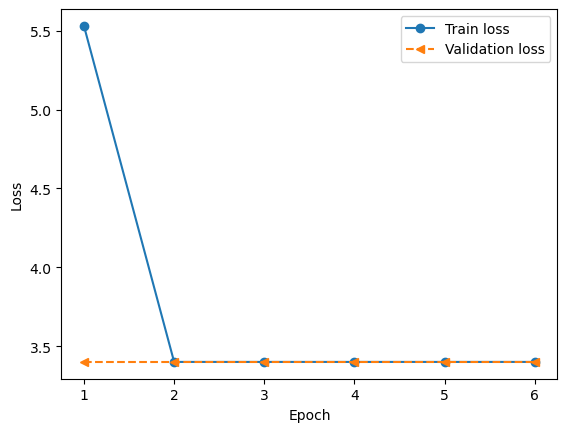

Training Accuracy: 0.03333333507180214
Validation Accuracy: 0.0019280206179246306


In [17]:
# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
history = model_1.fit(train_images_shuffled, train_labels_class_shuffled, epochs=10, validation_data=(val_images_shuffled, val_labels_class_shuffled), callbacks=[early_stopping])
print('Total params: ', model_1.count_params())

# plot loss curves
### YOUR CODE HERE ###
trained_model_epochs = history.history
x_arr = np.arange(len(trained_model_epochs['loss'])) + 1 
plt.plot(x_arr, trained_model_epochs['loss'], '-o', label='Train loss')
plt.plot(x_arr, trained_model_epochs['val_loss'], '--<', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
print('Training Accuracy:', trained_model_epochs['accuracy'][-1])
print('Validation Accuracy:', trained_model_epochs['val_accuracy'][-1])

In [ ]:
# Retrieve the training metrics (after each train epoch) and the final validation
# accuracy.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xlabel('Train epochs')
plt.legend()
plt.show()

print('Training accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])

In [18]:
print('Test Accuracy:', model_1.evaluate(test_images_shuffled, test_labels_class_shuffled)[-1])

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0000e+00 - loss: 3.4012
Test Accuracy: 0.0


In [ ]:
# initialize more complext CNN model
model_2 = tf.keras.Sequential()

# add convolutional layer
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_1', activation='relu'))
model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_2', activation='relu'))

# add max pooling layer 
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# add dropout layer
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.Flatten())

# add the classification layer
### YOUR CODE HERE ###
num_classes = len(set(train_labels_class_shuffled))
model_2.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# build and compile model
model_2.build(input_shape=(None, 224, 224, 3))
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
### YOUR CODE HERE ###
print(model_2.summary())

# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
trained_model = model_2.fit(train_images_shuffled, train_labels_class_shuffled, epochs=10, validation_data=(val_images_shuffled, val_labels_class_shuffled), callbacks=[early_stopping])
print('Total params: ', model_2.count_params())

# plot loss curves
### YOUR CODE HERE ###
trained_model_epochs = trained_model.history
x_arr = np.arange(len(trained_model_epochs['loss'])) + 1 
plt.plot(x_arr, trained_model_epochs['loss'], '-o', label='Train loss')
plt.plot(x_arr, trained_model_epochs['val_loss'], '--<', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
print('Training Accuracy:', trained_model_epochs['accuracy'][-1])
print('Validation Accuracy:', trained_model_epochs['val_accuracy'][-1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 224, 224, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │    24,084,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,118,910 (92.01 MB)

 Trainable params: 24,118,910 (92.01 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1184s 2s/step - accuracy: 0.0342 - loss: 5714.0376 - val_accuracy: 0.0488 - val_loss: 3.3511
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1230s 2s/step - accuracy: 0.0339 - loss: 3.4220 - val_accuracy: 0.0488 - val_loss: 3.3487
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8757s 16s/step - accuracy: 0.0337 - loss: 3.4226 - val_accuracy: 0.0488 - val_loss: 3.3483
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8657s 15s/step - accuracy: 0.0339 - loss: 3.4229 - val_accuracy: 0.0488 - val_loss: 3.3483
Epoch 5/10
140/563 ━━━━━━━━━━━━━━━━━━━━ 13:02 2s/step - accuracy: 0.0333 - loss: 3.4221

KeyboardInterrupt: 

In [ ]:
# Retrieve the training metrics (after each train epoch) and the final validation
# accuracy.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xlabel('Train epochs')
plt.legend()
plt.show()

print('Training accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])

In [ ]:
print('Test Accuracy:', model_2.evaluate(test_images_shuffled, test_labels_class_shuffled)[-1])

72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.0215 - loss: 3.3924
Test Accuracy: 0.024175824597477913


: 